### Sourcing Sprints assessment

In [134]:
import pandas as pd
from pathlib import Path

In [135]:
csv_path = Path("dummy_ecommerce_transactions.csv")
df = pd.read_csv(csv_path)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
# previewing
df.head(5)

Shape: (500, 5)
Columns: ['Customer ID', 'Transaction Date', 'Transaction Amount', 'Category', 'Region']


,Customer ID,Transaction Date,Transaction Amount,Category,Region
0,CUST029,2022-01-03,380.79,Clothing,East
1,CUST007,2022-01-06,951.21,Books,South
2,CUST071,2022-01-06,734.67,Health,North
3,CUST063,2022-01-12,602.67,Home,West
4,CUST058,2022-01-13,164.46,Health,East


In [137]:
dates = "Transaction Date"
revenues  = "Transaction Amount"

# dealing with bad values
df[dates] = pd.to_datetime(df[dates], errors="coerce") #NaT
df[revenues] = pd.to_numeric(df[revenues], errors="coerce") #NaN

print("Dtypes:")
print(df[[dates, revenues]].dtypes, "\n")

print("Invalid (coerced) dates:", df[dates].isna().sum())
print("Invalid (coerced) amounts:", df[revenues].isna().sum(), "\n")

print("Date range:", df[dates].min(), "to", df[dates].max())

Dtypes:
Transaction Date      datetime64[ns]
Transaction Amount           float64
dtype: object 

Invalid (coerced) dates: 0
Invalid (coerced) amounts: 0 

Date range: 2022-01-03 00:00:00 to 2024-12-29 00:00:00


In [139]:
# sort within each customer by date
df_sorted = df.sort_values(["Customer ID", "Transaction Date"]).copy()
# print(df_sorted.head(10))

df_sorted["prior_purchases"] = df_sorted.groupby("Customer ID").cumcount() #count purchases before

def tier_from_prior(n):
    if n == 0:
        return "New"
    elif 1 <= n <= 4:
        return "Active"
    else:
        return "Power User"

df_sorted["engagement_tier"] = df_sorted["prior_purchases"].apply(tier_from_prior)

df_sorted.head(10)

,Customer ID,Transaction Date,Transaction Amount,Category,Region,prior_purchases,engagement_tier
130,CUST001,2022-11-12,423.24,Clothing,East,0,New
144,CUST001,2022-12-22,291.99,Clothing,West,1,Active
250,CUST001,2023-08-03,301.50,Home,South,2,Active
348,CUST001,2024-03-09,380.87,Clothing,West,3,Active
435,CUST001,2024-08-17,703.96,Home,North,4,Active
462,CUST001,2024-09-27,748.58,Clothing,East,5,Power User
24,CUST002,2022-03-01,461.51,Electronics,South,0,New
186,CUST002,2023-04-14,819.05,Books,East,1,Active
120,CUST003,2022-10-26,809.37,Clothing,North,0,New
304,CUST003,2023-11-14,728.83,Clothing,North,1,Active


In [140]:
# by engagement tier
revenue_by_tier = (df_sorted.groupby("engagement_tier")["Transaction Amount"].sum().round(2).reset_index().sort_values("Transaction Amount", ascending=False))

revenue_by_tier


,engagement_tier,Transaction Amount
0,Active,161816.89
1,New,70954.36
2,Power User,19016.86


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 

In [144]:
start, end = pd.Timestamp("2022-01-01"), pd.Timestamp("2024-12-31")
df_range = df_sorted[(df_sorted["Transaction Date"] >= start) & (df_sorted["Transaction Date"] <= end)]
# print(df_range)

# aggregate by month & region
monthly = (df_range.groupby([pd.Grouper(key="Transaction Date", freq="MS"), "Region"])["Transaction Amount"].sum().unstack("Region").sort_index())

print(monthly)

Region               East    North    South     West
Transaction Date                                    
2022-01-01        1510.64   899.10  2267.30   602.67
2022-02-01        1145.24  1047.15  1584.02   970.21
2022-03-01        1560.87   596.49  2008.03  1914.68
2022-04-01        1147.75      NaN  1567.63  2163.75
2022-05-01        2055.77  2565.30  1394.70   777.38
2022-06-01        1376.57  1881.08  1168.73  2705.52
2022-07-01         990.72  1476.03  2555.19  1050.18
2022-08-01        1278.78  2109.90  1762.11  1414.44
2022-09-01         296.85  1964.40   962.77  1420.58
2022-10-01        1703.67  2478.42  1442.71   872.75
2022-11-01        3266.62  1955.35  1173.37  1457.61
2022-12-01         613.47   415.35  1639.18  2226.87
2023-01-01        2262.42  1958.70  1049.86  1480.35
2023-02-01         736.58   540.42      NaN  1409.54
2023-03-01        1477.93   575.49   826.94  2174.78
2023-04-01        3461.67  2440.79   249.43  2097.58
2023-05-01        2341.64  3297.79  1350.37  3

In [145]:
# fill missing months with 0
full_index = pd.date_range(start=start, end=end, freq="MS")
monthly = monthly.reindex(full_index).fillna(0)

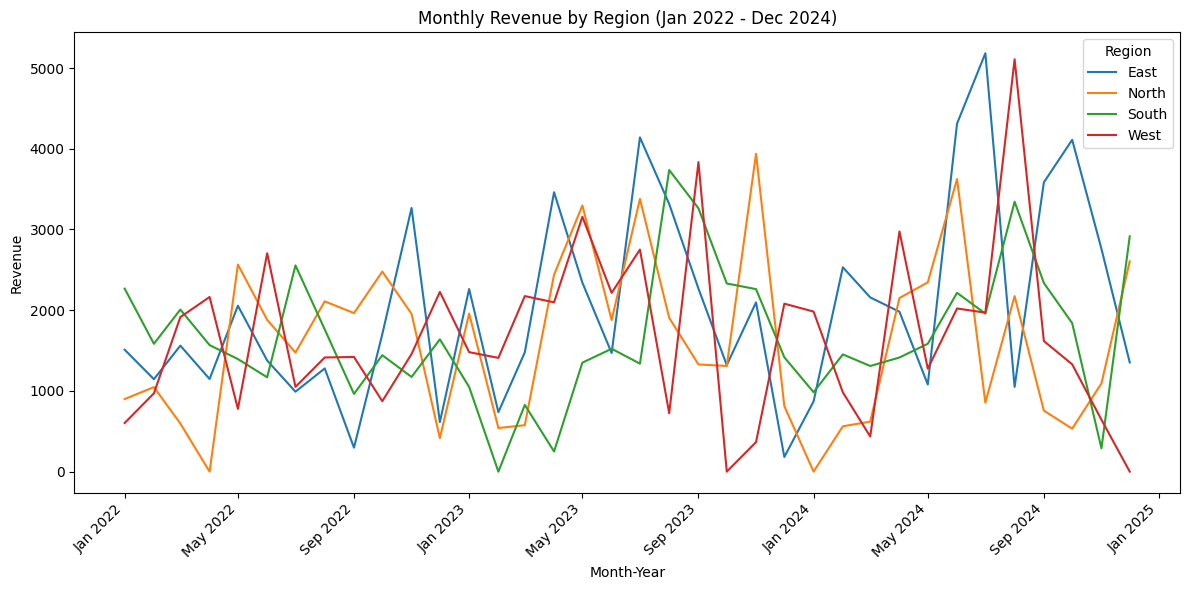

In [146]:
# plot
plt.figure(figsize=(12,6))
for region in monthly.columns:
    plt.plot(monthly.index, monthly[region], label=region)

plt.title("Monthly Revenue by Region (Jan 2022 - Dec 2024)")
plt.xlabel("Month-Year")
plt.ylabel("Revenue")

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45, ha="right")
plt.legend(title="Region")
plt.tight_layout()
plt.show()

In [149]:
# filtering for 2024
df_2024 = df_sorted[df_sorted["Transaction Date"].dt.year == 2024]
print(df_2024)

# aggregate
rev_by_category_2024 = (df_2024.groupby("Category")["Transaction Amount"].sum().round(2).reset_index().sort_values("Transaction Amount", ascending=False))

    Customer ID Transaction Date  Transaction Amount     Category Region  \
348     CUST001       2024-03-09              380.87     Clothing   West   
435     CUST001       2024-08-17              703.96         Home  North   
462     CUST001       2024-09-27              748.58     Clothing   East   
324     CUST003       2024-01-10              955.32        Books   West   
357     CUST003       2024-04-08              589.92        Books   West   
..          ...              ...                 ...          ...    ...   
430     CUST148       2024-08-10              151.56        Books   West   
493     CUST148       2024-12-23              196.24        Books  South   
419     CUST149       2024-07-24              754.85  Electronics  North   
467     CUST149       2024-10-04              869.91       Health  South   
364     CUST150       2024-04-21              942.05        Books  South   

     prior_purchases engagement_tier  
348                3          Active  
435      

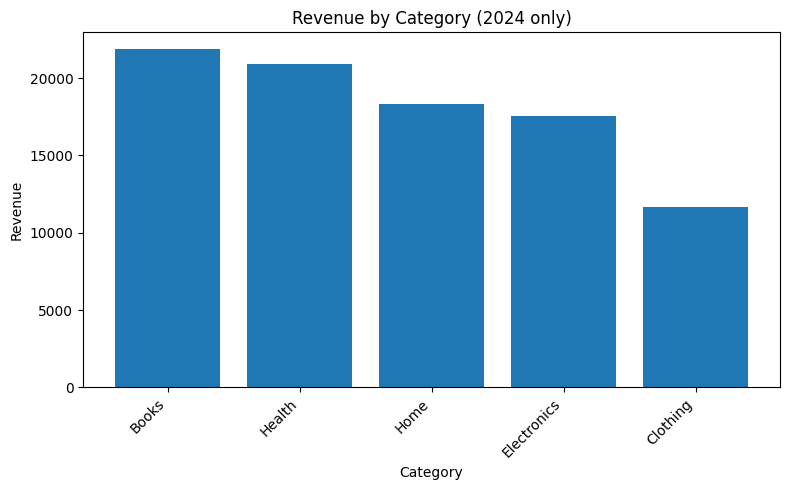

,Category,Transaction Amount
0,Books,21860.21
3,Health,20919.37
4,Home,18294.35
2,Electronics,17535.34
1,Clothing,11667.60


In [150]:
plt.figure(figsize=(8,5))
plt.bar(rev_by_category_2024["Category"], rev_by_category_2024["Transaction Amount"])
plt.title("Revenue by Category (2024 only)")
plt.xlabel("Category")
plt.ylabel("Revenue")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

rev_by_category_2024